In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
import vehicle_list_data
from simulation import Simulation
from vehicle_list_data import get_index_edge_totals
from tqdm import tqdm
from ast import literal_eval
from vehicle import get_edge_type_frequencies

# Set Analysis Set (and single sim)

In [2]:
basename = "low_volume_noreverse"
file_path = "trials/" + basename + "/"
reverse_scenario_labels = ["all_improved", "double_battery_capacity", "double_km_per_kwh", "double_charging_rate", "baseline"]
scenario_labels = list(reversed(reverse_scenario_labels))

In [3]:
num_scenarios = len(scenario_labels)
def get_pickles_by_scenario(file_path):
    pkls = os.listdir(file_path)
    per_scenario = {str(n):[] for n in range(num_scenarios)}
    for scenario in range(num_scenarios):
        for pkl in pkls:
            end_index = pkl.find('_algorithm_')
            if "scenario_"+str(scenario) in pkl or pkl[end_index-1:end_index]==str(scenario):
                per_scenario[str(scenario)].append(pkl)
    per_scenario = {key:sorted(per_scenario[key]) for key in per_scenario}
    return per_scenario
per_scenario = get_pickles_by_scenario(file_path)
per_scenario;

In [4]:
scenario_index = 0
alg_index = 4
pkl = per_scenario[str(scenario_index)][alg_index]
with open(file_path + pkl, 'rb') as inp:
    sim = pickle.load(inp)

# Graph Scenarios over Algorithm Iterations

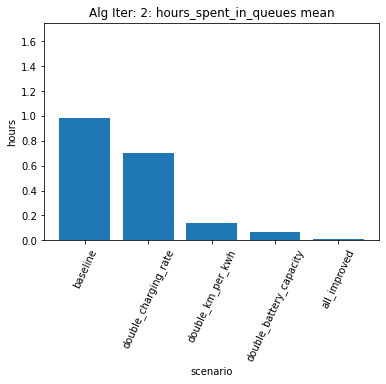

In [5]:
num_scenarios = len(list(per_scenario.keys()))
def graph_scenario(n, metric = "station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for pkl in per_scenario[str(n)]:
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("Scenario " + scenario_labels[n] + ": " + metric + " " + measurement_str)
    plt.ylabel("hour")
    plt.xlabel("iteration")
    plt.show()

def graph_algo_iteration(a, metric="station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for scenario in per_scenario:
        pkl = per_scenario[scenario][a]
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    fig, ax = plt.subplots(figsize = (6,4))
    ax.bar(list(range(len(scenario_labels))), data)
    measurement_str = measurement if measurement != None else ""
    ax.set_title("Alg Iter: " + str(a) + ": " + metric + " " + measurement_str)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(scenario_labels, rotation=65)
    ax.set_xlabel('scenario')
    ax.set_ylabel('hours')
    ax.set_ylim(0,1.75)
    plt.show()

# for scenario in range(num_scenarios):
#     graph_scenario(scenario, metric = "hours_spent_in_queues", measurement = None)
    
for algo_iter in range(2,3):
    graph_algo_iteration(algo_iter, metric = "hours_spent_in_queues", measurement = "mean")

# Extract Charging Station Information

In [6]:
def get_stations_used_passed(path):
    stations_used = []
    stations_passed = []
    for i, loc in enumerate(path):
        if i == len(path):
            break
        if "_in" in loc:
            next_loc = path[i+1]
            in_battery = loc.split("_")[1]
            out_battery = next_loc.split("_")[1]
            if "_out" in next_loc:
                node = loc.split("_")[0]
                if in_battery != out_battery:
                    stations_used.append(node)
                else:
                    stations_passed.append(node)
    return (stations_used, stations_passed)

def get_utilization_df(sim):
    station_used_counts = {node:0 for node in sim.station_g.nodes}
    station_passed_counts = {node:0 for node in sim.station_g.nodes}

    for vehicle in sim.vehicle_list:
        stations_used, stations_passed = get_stations_used_passed(vehicle.path)
        for station in stations_used:
            station_used_counts[station]+=1
        for station in stations_passed:
            station_passed_counts[station]+=1
    utilization_data = np.array([list(station_used_counts.keys()), list(station_used_counts.values()), list(station_passed_counts.values())]).T
    utilization_df = pd.DataFrame(utilization_data, columns = ["node", "used", "passed"])
    utilization_df = utilization_df.astype({"used": int, "passed": int})
    return utilization_df

def get_charging_passed_unseen(sim):
    utilization_df = get_utilization_df(sim)
    num_stations_unseen = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]==0)])
    num_stations_passed = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]!=0)])
    num_stations_charging = len(utilization_df.loc[(utilization_df["used"]!=0)])
    return (num_stations_charging, num_stations_passed, num_stations_unseen)

get_charging_passed_unseen(sim)

(30, 0, 13)

# Which stations are removed?

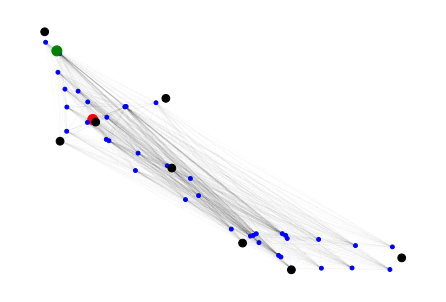

In [7]:
scenarios_df = pd.read_csv(file_path+basename+".csv", header=1)

def get_high_low_util_arr(scenario_index):
    scenario_df = scenarios_df[scenarios_df["scenario_number"]==scenario_index]
    arr = scenario_df[["most_utilized_node", "least_utilized_node"]].to_numpy()
    return arr

arr = get_high_low_util_arr(scenario_index);

G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 15
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "black"
    G.nodes[node]["size"] = 60
#high and low util
G.nodes[str(arr[alg_index][0])]["color"]="green"
G.nodes[str(arr[alg_index][0])]["size"]=100
G.nodes[str(arr[alg_index][1])]["color"]="red"
G.nodes[str(arr[alg_index][1])]["size"]=100
node_color = nx.get_node_attributes(G,'color').values() 
#static sizes and widths
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {edge:.005 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Assess src-dst distribution

In [8]:
print("Total vehicles: ", len(sim.vehicle_list))

Total vehicles:  1895


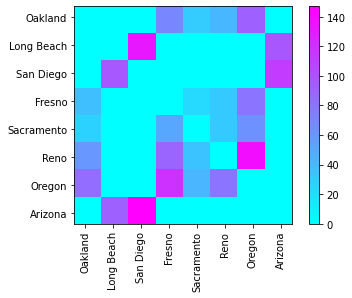

In [5]:
def get_src_dst_dict(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    destinations = {dst:0 for dst in demand_nodes}
    sources = {src:0 for src in demand_nodes}
    paths = {(src+"_src", dst+"_dst"):0 for src in demand_nodes for dst in demand_nodes}

    for vehicle in sim.vehicle_list:
        destinations[vehicle.dst]+=1
        sources[vehicle.src]+=1
        paths[(vehicle.src+"_src", vehicle.dst+"_dst")] +=1
    return paths;
    
def plot_src_dst_matrix(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    paths = get_src_dst_dict(sim)
    path_matrix = np.zeros((num_demand_nodes,num_demand_nodes))
    for r, src in enumerate(demand_nodes):
        for c, dst in enumerate(demand_nodes):
            path_matrix[r][c] = paths[(src+"_src",dst+"_dst")]
            
    fig, ax = plt.subplots(1,1)

    img = ax.imshow(path_matrix, cmap='cool', interpolation='nearest',extent=[-1,1,-1,1])
    ax.set_xticks(np.linspace(-.9, .9,len(demand_nodes)))
    ax.set_xticklabels(demand_nodes,rotation=90)
    ax.set_yticks(np.linspace(-.9, .9,len(demand_nodes)))
    ax.set_yticklabels(list(reversed(demand_nodes)),rotation=0)
    fig.colorbar(img)

plot_src_dst_matrix(sim)

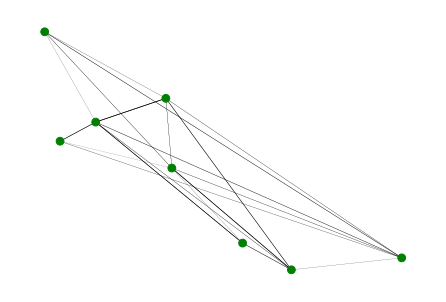

In [6]:
demand_nodes = list(sim.dst_dict.keys())
path_weights = get_src_dst_dict(sim)
G = sim.station_demand_g.subgraph(demand_nodes).copy()
sim_index = 50
G.add_edges_from([(src, dst) for src in demand_nodes for dst in demand_nodes if src!=dst])
for node in G.nodes:
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 60
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {(src,dst):path_weights[(src+'_src', dst+"_dst")]/200 for src in demand_nodes for dst in demand_nodes}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Static Graph

In [11]:
edge_totals = get_index_edge_totals(sim)

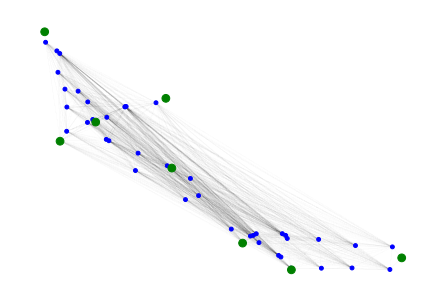

In [12]:
G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 15
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 60
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {edge:.005 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Assess demand (vehicles on each road)

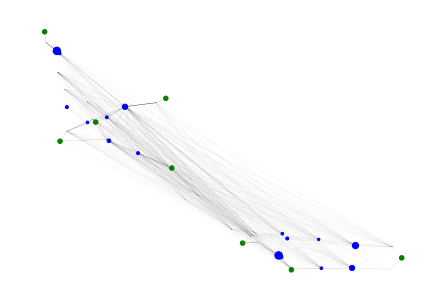

In [13]:
G = sim.station_demand_g
sim_index = 25
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 0
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Confirm queue charging and total at-station time

In [14]:
def get_time_at_charging_station(locations):
    sim_steps = 0
    for i, loc in enumerate(locations):
        if i == len(locations):
            break
        if "_in" in loc[0] and "_out" in loc[1]:
            in_battery = loc[0].split("_")[1]
            out_battery = loc[1].split("_")[1]
            if in_battery != out_battery:
                sim_steps+=1
    return sim_steps

In [15]:
charging_and_queue_time = []
charging_and_queue_time_sim = []
for vehicle in sim.vehicle_list:
    charging_and_queue_time.append(get_time_at_charging_station(vehicle.locations))
    charging_and_queue_time_sim.append(vehicle.queue_time)
qc_arr = np.array([charging_and_queue_time, charging_and_queue_time_sim]).T
qc_df = pd.DataFrame(qc_arr/5, columns = ["qc", "q_sim"])
print(max(qc_df["qc"]), max(qc_df["q_sim"]))

9.6 9.6


# Do vehicles with the same src dst take different paths?

In [16]:
def get_trip_unique_paths(sim):
    demand_nodes = list(sim.dst_dict.keys())
    trips = {(src, dst):{} for src in demand_nodes for dst in demand_nodes}
    for vehicle in sim.vehicle_list:
        if tuple(vehicle.path) in trips[(vehicle.src, vehicle.dst)]:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]+=1
        else:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]=0
    return trips

def get_number_trip_unique_paths(sim):
    trips = get_trip_unique_paths(sim)
    return [len(trips[key]) for key in trips]


print(get_number_trip_unique_paths(sim))

[0, 0, 0, 3, 1, 7, 8, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 3, 9, 12, 0, 1, 0, 0, 4, 0, 4, 7, 0, 6, 0, 0, 13, 3, 0, 17, 0, 11, 0, 0, 16, 8, 11, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0]


# Total vehicles in Queues

In [47]:
fully_saturated_charging = sum([sim.station_g.nodes[node]["physical_capacity"] for node in sim.station_g.nodes])

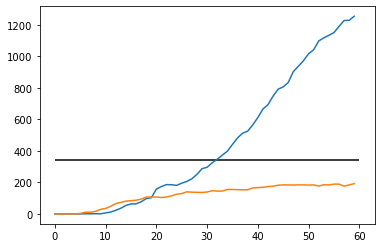

In [51]:
in_queue = vehicle_list_data.get_sim_index_counts(sim, "queue")
is_charging = vehicle_list_data.get_sim_index_counts(sim, "charging")
plt.plot(in_queue)
plt.plot(is_charging)
plt.hlines(fully_saturated_charging, 0, 60, color="black")
# is_charging

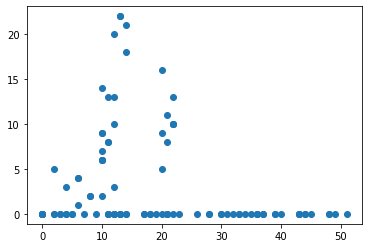

In [57]:
vehicle_list = [v for v in sim.vehicle_list if v.finished == True]
start_indices = [v.start_time for v in vehicle_list]
queue_time = [get_edge_type_frequencies(v)["queue"] for v in vehicle_list]
plt.scatter(start_indices, queue_time)

In [37]:
vehicle_list_data.get_hours_on_edge_type(sim, "unfinished")['queue'].mean()

2.890523968784838

# Compare metrics (csv)

In [17]:
file_path = "trials/arizona_baseline_results/"
scenarios_df = pd.read_csv(file_path+"arizona_baseline_results.csv", header=1)
scenarios_df.head(5)

,scenario_number,iteration,charging_rate,km_per_kwh,battery_capacity,success,station_utilization_disp_of_avg,station_utilization_avg_of_disp,electricity,percent_delay,hours_spent_in_queues,hours_spent_charging,most_utilized_node,least_utilized_node,strongly_connected_components,weakly_connected_components
0,0,0,45,1.9,215,True,112.592318,112.643620,0,"(1.0, 1.0, 8.786745675149971, 2.06866052627655...","(0.0, 0.0, 16.0, 2.095726495726496, 3.78639925...","(0, 0.0, 22, 3.6552706552706553, 6.49858361716...",16,1,296,44
1,0,1,45,1.9,215,True,105.816146,105.885547,0,"(1.0, 1.178656224377259, 8.92832281349943, 2.4...","(0.0, 0.0, 16.4, 2.3358490566037737, 4.0122028...","(0, 0.0, 22, 3.560646900269542, 6.073979109531...",37,2,289,44
2,0,2,45,1.9,215,True,93.070312,93.470052,0,"(1.0, 1.178656224377259, 9.677775848664693, 2....","(0.0, 0.0, 16.6, 2.7422960725075525, 4.5542310...","(0, 0.0, 22, 2.9637462235649545, 5.22183567712...",8,3,280,45
3,0,3,45,1.9,215,True,84.491146,85.222005,0,"(1.0, 1.3259882524244162, 8.837217478667803, 2...","(0.0, 0.0, 16.2, 2.791926182237601, 4.27129355...","(0, 0.0, 22, 3.1614763552479817, 4.84516826235...",37,4,270,45
4,0,4,45,1.9,215,True,81.721615,82.855208,0,"(1.0, 1.2356299794963432, 9.058374669813327, 2...","(0.0, 0.0, 16.2, 3.004574332909784, 4.82777641...","(0, 0.0, 24, 3.0584498094027954, 4.77303300875...",34,5,269,45


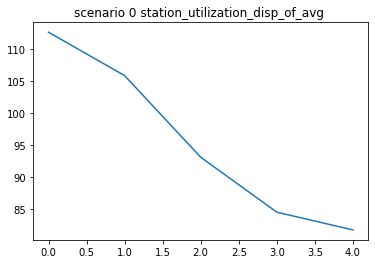

In [18]:
indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}

def plot_scenario_metric(scenarios_df, scenario_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["scenario_number"]==scenario_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("scenario " + str(scenario_index) + " " + metric + " " + measurement_str)
    
def plot_algorithm_iteration_metric(scenarios_df, alg_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["iteration"]==alg_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.xticks(rotation=90)
    plt.bar(list(range(len(df_slice))), data, tick_label = ["baseline"])
    measurement_str = measurement if measurement != None else ""
    plt.title("iteration " + str(alg_index) + " " + metric + " " + measurement_str)

plot_scenario_metric(scenarios_df, 0, "station_utilization_disp_of_avg")
# plot_scenario_metric(scenarios_df, 0, "hours_spent_in_queues", "mean")
# plot_algorithm_iteration_metric(scenarios_df, 0, "percent_delay", "med")
# plot_algorithm_iteration_metric(scenarios_df, 0, "station_utilization_disp_of_avg")

In [19]:
literal_eval(scenarios_df.iloc[0]["percent_delay"])

(1.0, 1.0, 8.786745675149971, 2.068660526276552, 1.7750273867306736)

## Percent Delay

### Validate hours spent in queues and hours spent charging

In simulation

In [20]:
print("Hours spent in queues:", sim.get_hours_spent_in_queues())
print("Hours spent charging:", sim.get_hours_spent_charging())

Hours spent in queues: (0.0, 0.0, 4.4, 0.6534653465346535, 1.1327321178369294)
Hours spent charging: (0, 9.0, 11, 5.415841584158416, 4.883326505271035)


In [21]:
vehicle_list_data.get_edge_hour_measurements(sim, "queue", "finished")

{'min': 0.0,
 'med': 0.0,
 'max': 4.4,
 'mean': 0.6534653465346535,
 'std': 1.1327321178369294,
 'sum': 66.0}

### Delay metric

In simulation

In [22]:
print("Percent delay:", sim.get_percent_delay())

Percent delay: (1.0, 2.00431736629579, 4.203478398914967, 1.9167945908838953, 0.8978221641101145)


In [23]:
vehicle_list_data.get_hours_on_edge_type(sim);

In [24]:
def get_percent_delay_metric(sim):
    hours_on_edge_types = vehicle_list_data.get_hours_on_edge_type(sim)
    delay = hours_on_edge_types["queue"]+hours_on_edge_types["charging"]
    baseline = hours_on_edge_types["road"]+hours_on_edge_types["src"]+hours_on_edge_types["dst"]
    percent_delay = (baseline+delay)/baseline
    d = {"min": np.min(percent_delay), 
         "med": np.median(percent_delay), 
         "max": np.max(percent_delay),
         "mean": np.mean(percent_delay),
         "std": np.std(percent_delay)}
    return d

get_percent_delay_metric(sim)

{'min': 1.0,
 'med': 1.769230769230769,
 'max': 3.3846153846153846,
 'mean': 1.6536557501904037,
 'std': 0.6847587149186419}

## Utilization

In simulation

In [25]:
print("Avg of station utilization dispersion:", sim.get_station_utilization_avg_of_disp())
print("Disp of station utilization avg:", sim.get_station_utilization_disp_of_avg())

Avg of station utilization dispersion: 5.659895833333334
Disp of station utilization avg: 5.229947916666667


In [26]:
print("Avg of station utilization dispersion:", vehicle_list_data.get_utilization_metric(sim, "avg_of_disp"))
print("Disp of station utilization avg:", vehicle_list_data.get_utilization_metric(sim, "disp_of_avg"))

Avg of station utilization dispersion: 5.5515625
Disp of station utilization avg: 5.131510416666667


## Peak Demand Exceedance

In simulation

In [27]:
print("Electricity peak excess:", sim.get_electricity_metric())
vehicle_list_data.get_electricity_metric(sim)

Electricity peak exccedance: 0


0.0